## **Wasserstein Generative Adversarial Network**
The Wasserstein GAN, or WGAN for short, was introduced by Martin Arjovsky, et al. in their 2017 paper titled Wasserstein GAN. It is an extension of the GAN that seeks an alternate way of training the generator model to better approximate the distribution of data observed in a given training dataset. <br>
Instead of using a discriminator to classify or predict the probability
of generated images as being real or fake, the WGAN changes or replaces the discriminator model with a critic that scores the realness or fakeness of a given image. <br>
This change is motivated by a mathematical argument that training the generator should seek a minimization of the distance between the distribution of the data observed in the training dataset and the
distribution observed in generated examples. The argument contrasts different distribution distance measures, such as Kullback-Leibler (KL) divergence, Jensen-Shannon (JS) divergence, and the Earth-Mover (EM) distance, the latter also referred to as Wasserstein distance.

The benefit of the WGAN is that the training process is more stable and less sensitive to model architecture and choice of hyperparameter configurations. Perhaps most importantly, the loss of the discriminator appears to relate to the quality of images created by the generator.

Specifically, the lower the loss of the critic when evaluating
generated images, the higher the expected quality of the generated images. This is important as unlike other GANs that seek stability in terms of finding an equilibrium between two models, the WGAN seeks convergence, lowering generator loss. 

**The differences in implementation for the WGAN are as follows:**
1.   Use a linear activation function in the output layer of the critic model (instead of sigmoid).
2.   Use -1 labels for real images and 1 labels for fake images (instead of 1 and 0).
2.   Use Wasserstein loss to train the critic and generator models.
1.   Constrain critic model weights to a limited range after each mini batch update (e.g. [-0.01,0.01]).
2.   Update the critic model more times than the generator each iteration (e.g. 5).
1.   Use the RMSProp version of gradient descent with a small learning rate and no momentum (e.g. 0.00005).

## **How to Implement Wasserstein Loss**
The Wasserstein loss function seeks to increase the gap between the scores for real and generated
images. We can summarize the function as it is described in the paper as follows:
*   **Critic Loss** = [average critic score on real images] - [average critic score on fake images]

*   **Generator Loss** = -[average critic score on fake images]

Where the average scores are calculated across a minibatch of samples.
In the case of the generator, a larger score from the
critic will result in a smaller loss for the generator, encouraging the critic to output larger scores for fake images. For example, an average score of 10 becomes -10, an average score of 50 becomes -50, which is smaller, and so on.

In the case of the critic, a larger score for real images results in a larger resulting loss for the critic, penalizing the model. This encourages the critic to output smaller scores for real
images. For example, an average score of 20 for real images and 50 for fake images results in a loss of -30; an average score of 10 for real images and 50 for fake images results in a loss of -40, which is better, and so on. <br>
A good way to think about this is  negative score for real images and a positive score for fake images
*   **Small Critic Score** (e.g.< 0): Real
*   **Large Critic Score** (e.g. >0): Fake

*   **Wasserstein Loss** = Label × Average Critic Score
*   **Wasserstein Loss(Fake Images)** = 1 × Average Predicted Score
*   **Wasserstein Loss(Real Images)** = -1 × Average Predicted Score

In [1]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot as plt

In [2]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [3]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [21]:
# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(learning_rate=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

In [22]:
# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

In [25]:
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(learning_rate=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

In [26]:
# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# select all of the examples for a given class
	selected_ix = trainy == 7
	X = trainX[selected_ix]
	# expand to 3d, e.g. add channels
	X = expand_dims(X, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [27]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

In [28]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [29]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

In [30]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
  # prepare fake examples
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot images
  for i in range(10 * 10):
    # define subplot
    plt.subplot(10, 10, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X[i, :, :, 0], cmap='gray_r')
  # save plot to file
  #filename1 = 'generated_plot_%04d.png' % (step+1)
  #pyplot.savefig(filename1)
  #pyplot.close()
  plt.show()
  # save the generator model
  filename = 'model_%04d.h5' % (step+1)
  g_model.save(filename)
  print('>>>Saved: %s' % (filename))

In [31]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
  # plot history
  plt.plot(d1_hist, label='crit_real')
  plt.plot(d2_hist, label='crit_fake')
  plt.plot(g_hist, label='gen')
  plt.legend()
  plt.show()
  #plt.savefig('plot_line_plot_loss.png')
  #plt.close() 

In [32]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)

11501568/11490434 [==============================] - 0s 0us/step
(6265, 28, 28, 1)
>1, c1=-2.062, c2=0.012 g=-0.242
>2, c1=-6.733, c2=0.101 g=-1.642
>3, c1=-9.784, c2=0.159 g=-2.561
>4, c1=-12.273, c2=0.215 g=-3.515
>5, c1=-14.538, c2=0.259 g=-4.738
>6, c1=-16.038, c2=0.304 g=-5.237
>7, c1=-17.575, c2=0.345 g=-5.962
>8, c1=-18.404, c2=0.372 g=-6.759
>9, c1=-20.623, c2=0.428 g=-7.723
>10, c1=-21.705, c2=0.454 g=-8.373
>11, c1=-22.246, c2=0.517 g=-9.274
>12, c1=-22.960, c2=0.587 g=-10.287
>13, c1=-24.163, c2=0.637 g=-11.002
>14, c1=-24.833, c2=0.694 g=-11.711
>15, c1=-25.306, c2=0.718 g=-12.480
>16, c1=-26.006, c2=0.778 g=-13.033
>17, c1=-26.432, c2=0.826 g=-13.069
>18, c1=-27.050, c2=0.860 g=-13.945
>19, c1=-27.989, c2=0.842 g=-13.784
>20, c1=-28.527, c2=0.890 g=-14.149
>21, c1=-29.275, c2=0.911 g=-14.690
>22, c1=-29.433, c2=1.068 g=-15.891
>23, c1=-30.232, c2=1.110 g=-16.556
>24, c1=-30.908, c2=1.212 g=-17.094
>25, c1=-31.277, c2=1.180 g=-18.054
>26, c1=-31.833, c2=1.131 g=-19.219
>27,

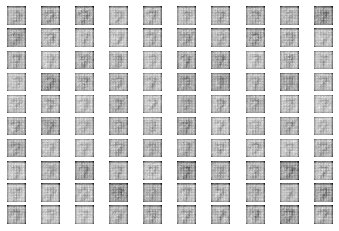

>>>Saved: model_0097.h5
>98, c1=-75.682, c2=-66.933 g=-73.906
>99, c1=-76.941, c2=-67.885 g=-74.783
>100, c1=-77.403, c2=-68.409 g=-74.807
>101, c1=-78.102, c2=-69.515 g=-76.158
>102, c1=-79.548, c2=-70.070 g=-77.385
>103, c1=-78.565, c2=-70.986 g=-77.274
>104, c1=-80.576, c2=-71.649 g=-78.247
>105, c1=-81.112, c2=-72.433 g=-79.289
>106, c1=-81.858, c2=-73.185 g=-80.055
>107, c1=-82.534, c2=-73.776 g=-80.862
>108, c1=-82.290, c2=-74.894 g=-81.227
>109, c1=-84.237, c2=-75.301 g=-81.782
>110, c1=-84.768, c2=-76.474 g=-82.772
>111, c1=-85.170, c2=-76.948 g=-82.928
>112, c1=-86.146, c2=-77.960 g=-84.653
>113, c1=-86.841, c2=-78.113 g=-85.413
>114, c1=-87.210, c2=-79.279 g=-86.841
>115, c1=-88.553, c2=-79.801 g=-87.283
>116, c1=-88.870, c2=-80.772 g=-88.743
>117, c1=-89.524, c2=-81.565 g=-88.786
>118, c1=-89.894, c2=-82.453 g=-89.980
>119, c1=-90.650, c2=-83.160 g=-91.027
>120, c1=-92.245, c2=-83.770 g=-91.451
>121, c1=-93.013, c2=-84.734 g=-91.774
>122, c1=-93.385, c2=-85.623 g=-92.709
>12

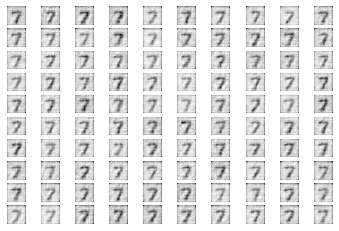

>>>Saved: model_0194.h5
>195, c1=-149.395, c2=-145.292 g=-157.323
>196, c1=-150.354, c2=-145.523 g=-158.140
>197, c1=-152.191, c2=-146.688 g=-158.880
>198, c1=-151.888, c2=-147.362 g=-158.219
>199, c1=-153.748, c2=-149.240 g=-160.015
>200, c1=-154.582, c2=-148.844 g=-161.722
>201, c1=-154.290, c2=-150.135 g=-160.988
>202, c1=-156.223, c2=-151.555 g=-162.746
>203, c1=-155.570, c2=-151.355 g=-163.601
>204, c1=-157.627, c2=-152.920 g=-165.095
>205, c1=-158.576, c2=-153.516 g=-166.080
>206, c1=-159.809, c2=-154.001 g=-166.782
>207, c1=-160.692, c2=-155.369 g=-167.813
>208, c1=-161.035, c2=-156.017 g=-168.710
>209, c1=-162.268, c2=-156.747 g=-169.430
>210, c1=-162.532, c2=-158.087 g=-169.871
>211, c1=-163.251, c2=-159.469 g=-171.059
>212, c1=-164.511, c2=-159.331 g=-172.171
>213, c1=-165.542, c2=-160.070 g=-172.500
>214, c1=-166.317, c2=-161.942 g=-172.672
>215, c1=-166.006, c2=-163.357 g=-174.273
>216, c1=-168.868, c2=-163.464 g=-174.683
>217, c1=-169.058, c2=-164.872 g=-176.364
>218, c1=-

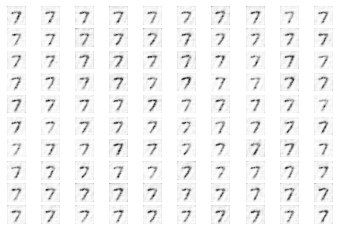

>>>Saved: model_0291.h5
>292, c1=-234.808, c2=-232.070 g=-245.552
>293, c1=-236.538, c2=-233.406 g=-246.865
>294, c1=-236.756, c2=-232.949 g=-246.195
>295, c1=-238.540, c2=-236.648 g=-248.380
>296, c1=-240.127, c2=-235.207 g=-249.388
>297, c1=-239.396, c2=-234.097 g=-249.844
>298, c1=-239.123, c2=-236.868 g=-250.236
>299, c1=-241.490, c2=-239.351 g=-251.237
>300, c1=-242.897, c2=-241.878 g=-253.038
>301, c1=-243.343, c2=-239.309 g=-253.374
>302, c1=-245.410, c2=-242.770 g=-254.366
>303, c1=-245.371, c2=-244.392 g=-256.111
>304, c1=-245.507, c2=-240.655 g=-252.133
>305, c1=-247.034, c2=-248.055 g=-257.635
>306, c1=-249.041, c2=-247.017 g=-257.962
>307, c1=-249.619, c2=-248.927 g=-259.591
>308, c1=-250.320, c2=-249.369 g=-260.683
>309, c1=-251.876, c2=-245.924 g=-260.984
>310, c1=-251.283, c2=-249.201 g=-261.932
>311, c1=-252.458, c2=-251.475 g=-263.955
>312, c1=-255.450, c2=-249.372 g=-264.264
>313, c1=-252.368, c2=-249.861 g=-264.722
>314, c1=-254.868, c2=-253.221 g=-265.623
>315, c1=-

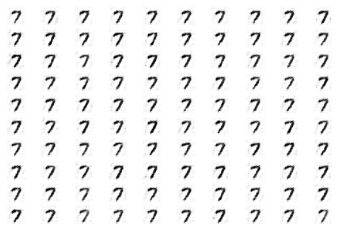

>>>Saved: model_0388.h5
>389, c1=-53.731, c2=-28.364 g=-199.639
>390, c1=-13.203, c2=-34.114 g=-182.546
>391, c1=-14.908, c2=-34.814 g=-175.374
>392, c1=7.135, c2=-14.323 g=-155.983
>393, c1=-17.037, c2=-26.428 g=-149.789
>394, c1=2.518, c2=-38.005 g=-152.625
>395, c1=-17.899, c2=-42.074 g=-151.726
>396, c1=-8.417, c2=-53.215 g=-159.620
>397, c1=5.945, c2=-54.454 g=-155.376
>398, c1=-7.980, c2=-61.178 g=-158.751
>399, c1=-4.776, c2=-69.630 g=-163.874
>400, c1=-21.008, c2=-66.247 g=-166.039
>401, c1=-21.208, c2=-72.434 g=-170.821
>402, c1=-16.026, c2=-72.415 g=-172.186
>403, c1=-32.033, c2=-69.837 g=-176.564
>404, c1=-27.181, c2=-68.652 g=-176.244
>405, c1=-32.771, c2=-61.173 g=-174.652
>406, c1=-36.582, c2=-59.985 g=-173.436
>407, c1=-31.068, c2=-50.851 g=-170.168
>408, c1=-36.687, c2=-48.547 g=-163.503
>409, c1=-39.376, c2=-43.383 g=-161.605
>410, c1=-42.021, c2=-41.180 g=-155.134
>411, c1=-48.687, c2=-34.470 g=-152.410
>412, c1=-49.963, c2=-29.581 g=-150.060
>413, c1=-58.401, c2=-26.

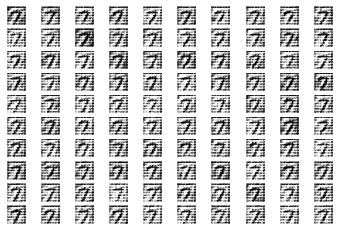

>>>Saved: model_0485.h5
>486, c1=-379.243, c2=-364.075 g=185.721
>487, c1=-380.985, c2=-366.365 g=182.973
>488, c1=-382.078, c2=-367.077 g=182.626
>489, c1=-383.365, c2=-368.794 g=185.505
>490, c1=-384.696, c2=-370.506 g=177.845
>491, c1=-385.778, c2=-370.400 g=176.860
>492, c1=-388.382, c2=-373.925 g=176.743
>493, c1=-390.138, c2=-374.680 g=183.276
>494, c1=-391.030, c2=-374.798 g=184.431
>495, c1=-394.250, c2=-378.207 g=171.107
>496, c1=-393.389, c2=-379.093 g=180.516
>497, c1=-394.405, c2=-379.229 g=177.195
>498, c1=-396.311, c2=-381.013 g=175.726
>499, c1=-397.018, c2=-382.697 g=172.439
>500, c1=-399.511, c2=-381.773 g=183.993
>501, c1=-400.515, c2=-383.594 g=176.856
>502, c1=-402.261, c2=-385.007 g=184.713
>503, c1=-405.576, c2=-388.636 g=170.119
>504, c1=-406.092, c2=-388.927 g=180.441
>505, c1=-408.768, c2=-390.147 g=182.836
>506, c1=-409.344, c2=-391.877 g=184.655
>507, c1=-410.769, c2=-394.570 g=183.429
>508, c1=-411.086, c2=-393.823 g=186.497
>509, c1=-413.152, c2=-396.346 g=

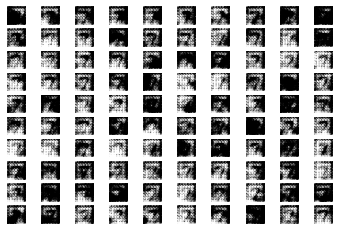

>>>Saved: model_0582.h5
>583, c1=-514.071, c2=-479.773 g=433.190
>584, c1=-513.492, c2=-481.231 g=441.941
>585, c1=-515.855, c2=-481.289 g=448.948
>586, c1=-517.873, c2=-483.092 g=454.815
>587, c1=-519.021, c2=-482.981 g=458.880
>588, c1=-520.497, c2=-485.334 g=461.939
>589, c1=-523.754, c2=-485.349 g=467.855
>590, c1=-525.345, c2=-484.739 g=473.349
>591, c1=-524.350, c2=-486.012 g=474.483
>592, c1=-527.368, c2=-487.844 g=475.540
>593, c1=-530.542, c2=-487.511 g=478.368
>594, c1=-531.508, c2=-487.899 g=482.855
>595, c1=-530.834, c2=-487.779 g=484.201
>596, c1=-533.403, c2=-488.801 g=486.470
>597, c1=-536.795, c2=-489.695 g=488.945
>598, c1=-536.910, c2=-490.954 g=490.487
>599, c1=-539.557, c2=-491.268 g=493.018
>600, c1=-540.214, c2=-493.035 g=494.173
>601, c1=-542.615, c2=-494.805 g=495.205
>602, c1=-544.112, c2=-496.133 g=497.908
>603, c1=-545.588, c2=-498.813 g=499.138
>604, c1=-548.787, c2=-500.344 g=500.827
>605, c1=-548.198, c2=-502.267 g=502.404
>606, c1=-549.478, c2=-503.664 g=

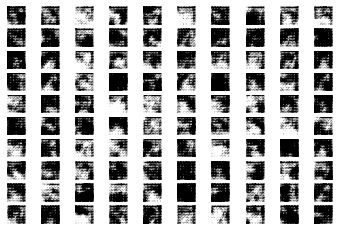

>>>Saved: model_0679.h5
>680, c1=-643.119, c2=-578.517 g=583.444
>681, c1=-644.711, c2=-579.402 g=587.028
>682, c1=-644.201, c2=-570.133 g=586.028
>683, c1=-646.595, c2=-581.452 g=589.316
>684, c1=-648.450, c2=-577.430 g=588.358
>685, c1=-648.186, c2=-573.913 g=584.138
>686, c1=-647.684, c2=-578.064 g=586.604
>687, c1=-650.542, c2=-578.794 g=589.807
>688, c1=-651.906, c2=-582.199 g=593.117
>689, c1=-653.484, c2=-586.448 g=592.437
>690, c1=-653.132, c2=-586.784 g=594.500
>691, c1=-655.219, c2=-586.562 g=594.217
>692, c1=-656.967, c2=-590.283 g=595.966
>693, c1=-659.713, c2=-591.163 g=597.124
>694, c1=-660.132, c2=-596.263 g=601.117
>695, c1=-661.262, c2=-597.125 g=602.084
>696, c1=-663.031, c2=-599.331 g=602.143
>697, c1=-665.678, c2=-592.573 g=602.111
>698, c1=-665.298, c2=-598.899 g=605.661
>699, c1=-668.343, c2=-603.012 g=606.979
>700, c1=-666.985, c2=-601.527 g=605.211
>701, c1=-668.735, c2=-596.252 g=607.253
>702, c1=-671.247, c2=-601.231 g=606.800
>703, c1=-670.352, c2=-598.894 g=

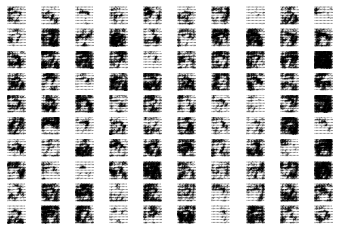

>>>Saved: model_0776.h5
>777, c1=-754.728, c2=-676.209 g=-446.931
>778, c1=-754.147, c2=-682.802 g=-442.007
>779, c1=-758.474, c2=-698.506 g=-462.889
>780, c1=-758.570, c2=-685.929 g=-459.388
>781, c1=-761.581, c2=-699.530 g=-458.265
>782, c1=-764.176, c2=-697.123 g=-445.135
>783, c1=-764.927, c2=-699.558 g=-455.669
>784, c1=-768.261, c2=-703.851 g=-469.858
>785, c1=-769.420, c2=-710.291 g=-477.496
>786, c1=-771.951, c2=-715.128 g=-489.743
>787, c1=-774.618, c2=-718.138 g=-505.707
>788, c1=-777.770, c2=-725.423 g=-526.852
>789, c1=-780.343, c2=-729.363 g=-563.578
>790, c1=-783.762, c2=-731.699 g=-588.130
>791, c1=-786.594, c2=-735.841 g=-608.871
>792, c1=-788.682, c2=-740.033 g=-630.005
>793, c1=-791.052, c2=-741.215 g=-643.507
>794, c1=-792.886, c2=-744.894 g=-661.846
>795, c1=-796.207, c2=-745.829 g=-669.382
>796, c1=-795.969, c2=-746.028 g=-677.809
>797, c1=-797.519, c2=-748.588 g=-690.611
>798, c1=-799.154, c2=-743.820 g=-708.198
>799, c1=-801.126, c2=-744.242 g=-723.571
>800, c1=-

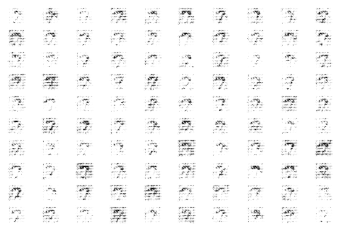

>>>Saved: model_0873.h5
>874, c1=-545.353, c2=-187.300 g=-323.549
>875, c1=-543.677, c2=-92.880 g=-254.199
>876, c1=-527.575, c2=-241.748 g=-274.968
>877, c1=-540.573, c2=-384.026 g=-272.975
>878, c1=-550.258, c2=-329.830 g=-199.071
>879, c1=-547.635, c2=-408.598 g=-152.655
>880, c1=-537.524, c2=-401.318 g=-58.851
>881, c1=-530.630, c2=-421.663 g=57.642
>882, c1=-526.301, c2=-444.911 g=143.244
>883, c1=-514.517, c2=-463.154 g=213.139
>884, c1=-506.617, c2=-503.319 g=273.445
>885, c1=-512.394, c2=-528.769 g=332.909
>886, c1=-518.749, c2=-548.259 g=435.142
>887, c1=-511.209, c2=-581.632 g=530.286
>888, c1=-515.361, c2=-609.486 g=586.625
>889, c1=-524.227, c2=-638.095 g=651.429
>890, c1=-535.360, c2=-661.404 g=684.909
>891, c1=-551.810, c2=-689.166 g=706.817
>892, c1=-561.203, c2=-702.679 g=721.998
>893, c1=-584.902, c2=-717.368 g=737.163
>894, c1=-592.436, c2=-727.375 g=747.871
>895, c1=-600.948, c2=-744.942 g=756.991
>896, c1=-617.873, c2=-753.931 g=765.407
>897, c1=-632.762, c2=-762.07

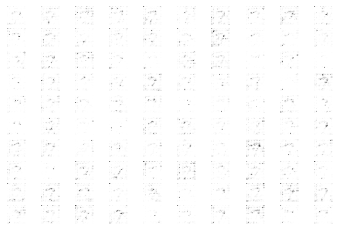

>>>Saved: model_0970.h5


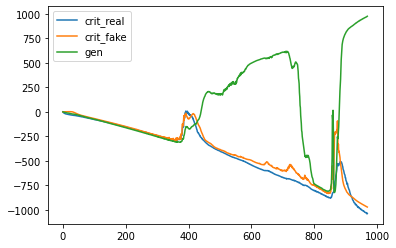

In [33]:
# size of the latent space
latent_dim = 50
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)

### How to Generate Images With WGAN

In [36]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

In [37]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [38]:
# create a plot of generated images (reversed grayscale)
def plot_generated(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

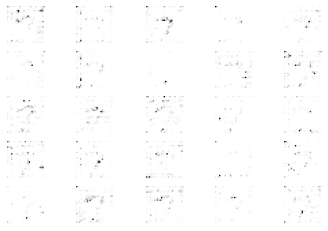

In [40]:
# load model
model = load_model('model_0970.h5',compile=False)
# generate images
latent_points = generate_latent_points(50, 25)
# generate images
X = model.predict(latent_points)
# plot the result
plot_generated(X, 5)